In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# load dataset
file_path = "./TrainDataset2024.xls"  # path to data
data = pd.read_excel(file_path)

# check data info
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [3]:
# Step 1: Missing values are processed
# Replace 999 with NaN
data.replace(999, np.nan, inplace=True)

# Check the missing values
print(data.isnull().sum())

# For categorical variables, fill with mode
categorical_features = ['ER', 'HER2', 'Gene', 'TrippleNegative', 'HistologyType']
for col in categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    data[col] = imputer_cat.fit_transform(data[[col]])

ID                               0
pCR (outcome)                    5
RelapseFreeSurvival (outcome)    0
Age                              0
ER                               0
                                ..
original_ngtdm_Busyness          0
original_ngtdm_Coarseness        0
original_ngtdm_Complexity        0
original_ngtdm_Contrast          0
original_ngtdm_Strength          0
Length: 121, dtype: int64


In [4]:
# For numeric variables, fill with the median
numerical_features = [col for col in data.columns if col not in categorical_features + ['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']]
imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Step 2: Outlier detection and handling
# Detecting Outliers Using the Boxplot Method (Example: Tumour Proliferation)
for col in numerical_features:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Replace the outlier with the boundary value
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [5]:
# Step 3: Data normalization
# Select the columns that need to be normalized (usually numeric features)
scaler = MinMaxScaler()  # or use StandardScaler
data[numerical_features] = scaler.fit_transform(data[numerical_features])


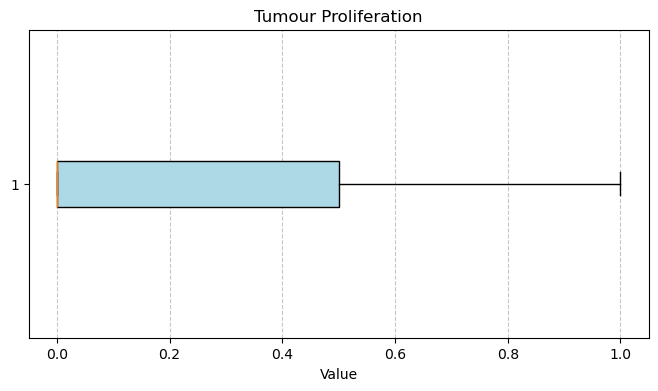

In [6]:
plt.figure(figsize=(8, 4))
plt.boxplot(data['Proliferation'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Tumour Proliferation')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

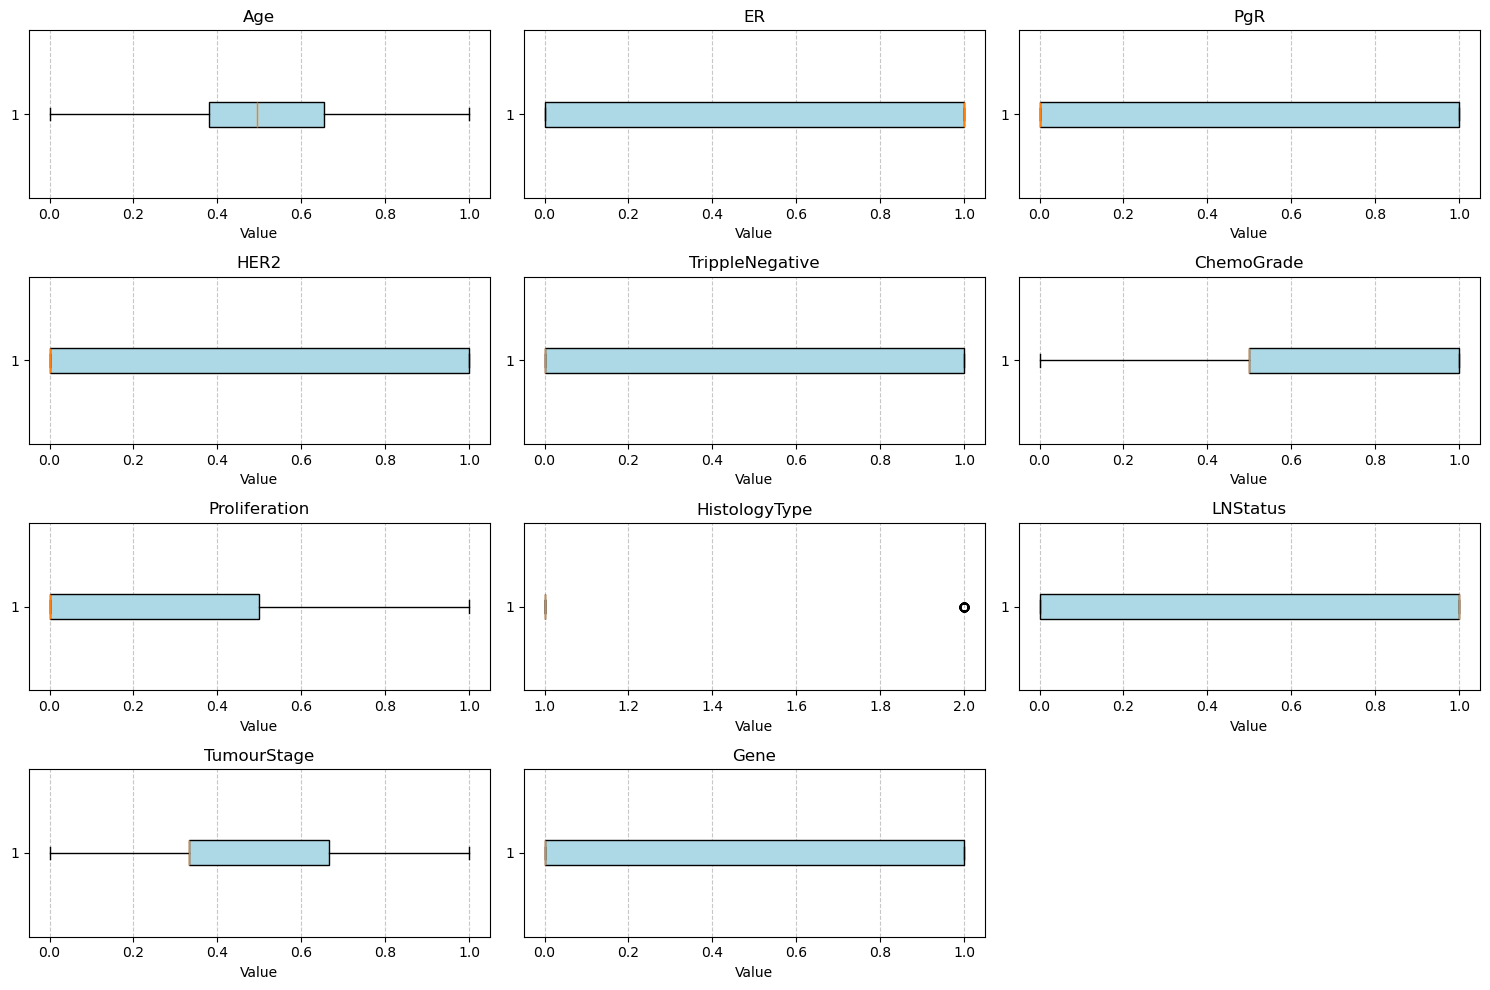

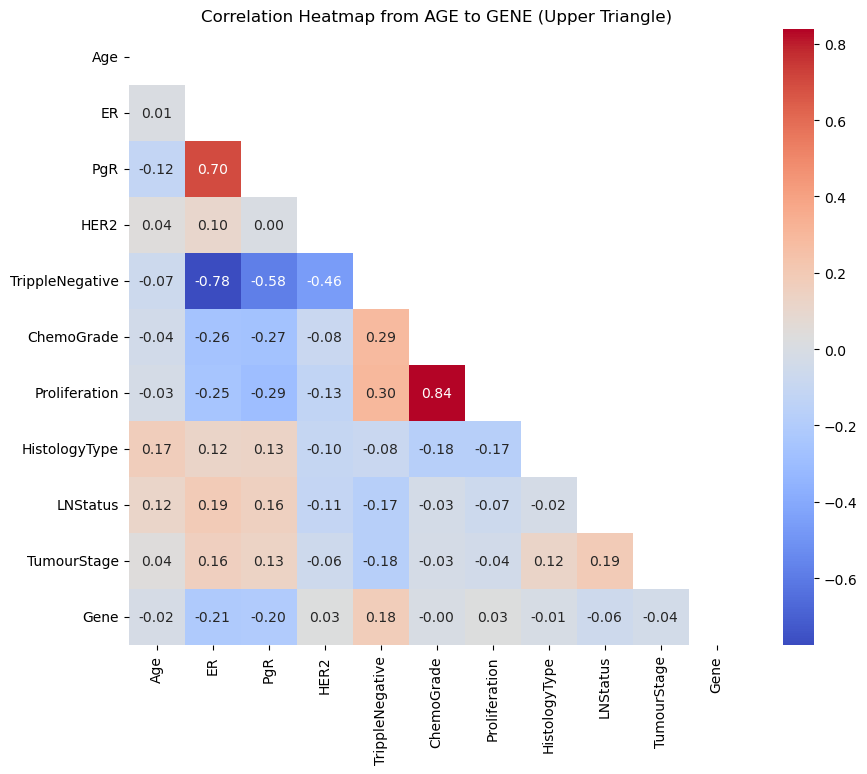

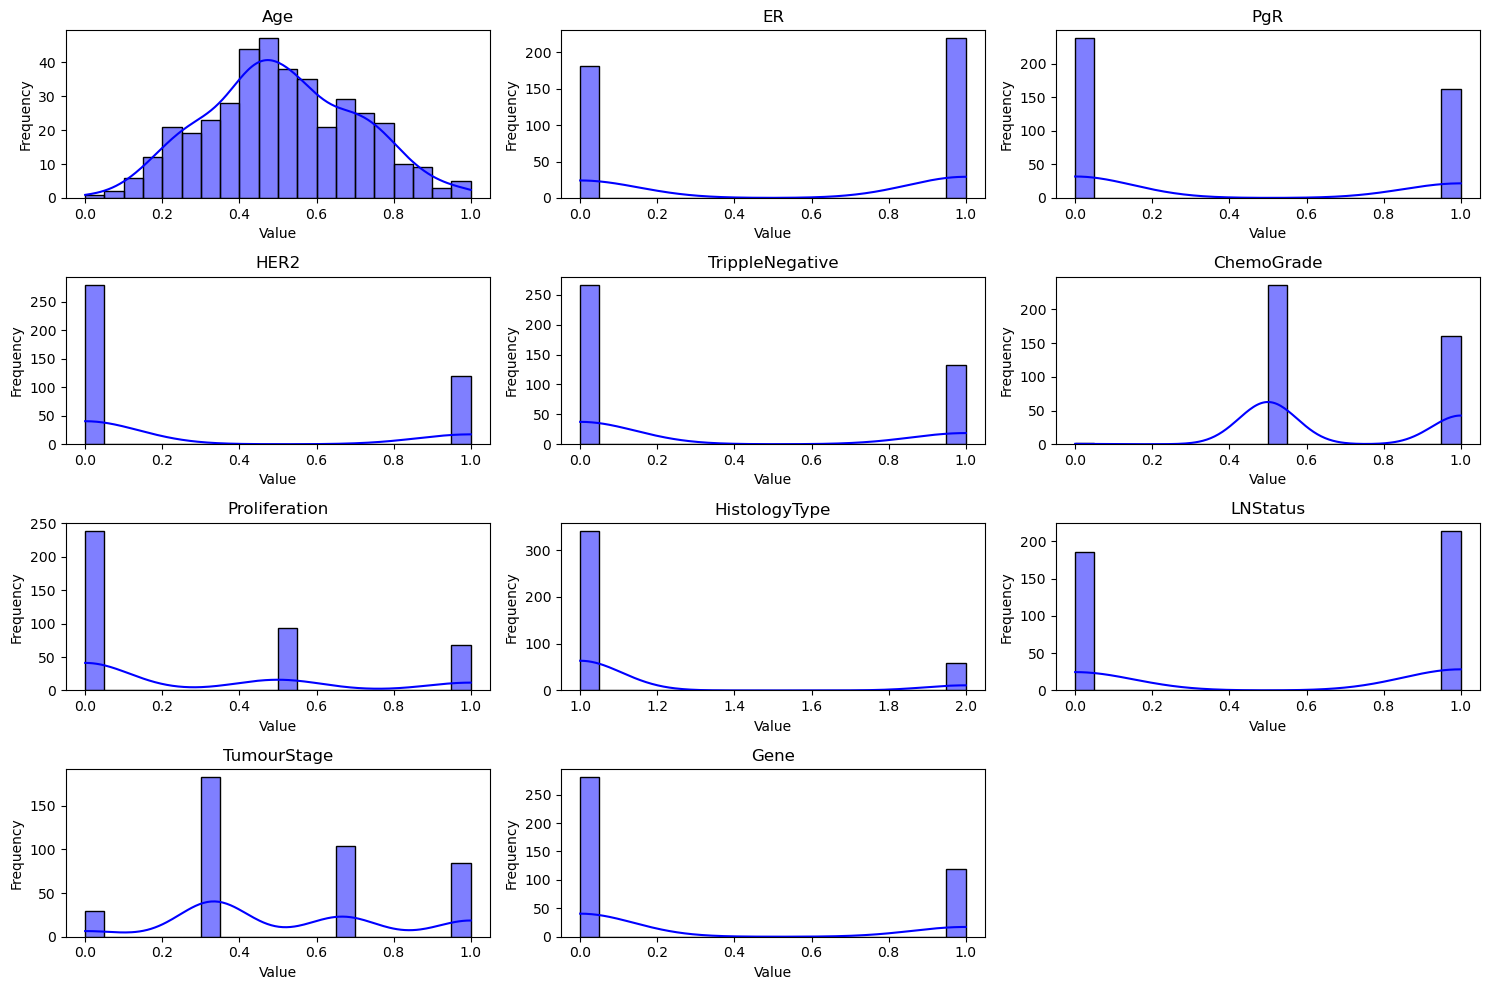

In [7]:
# Select the AGE to GENE column
selected_columns = data.loc[:, 'Age':'Gene']

# Step 1: Draw a boxplot
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: Draw a correlation heat map
# Calculate the correlation matrix
corr_matrix = selected_columns.corr()

# Mapping thermal imaging distributions using Seaborn

plt.figure(figsize=(10, 8))

# Create a mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

#  Seaborn dipict the heat 
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")

plt.show()

# Step 3: dipict 
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # dynamic arrange
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
# Step 4: arrange dataset
# District features and target
X = data.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])  # get rid of ID pcR RFS
y_pcr = data['pCR (outcome)']  # classific target
y_rfs = data['RelapseFreeSurvival (outcome)']  # regression Target

In [9]:
print(y_pcr)

0      1.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: pCR (outcome), Length: 400, dtype: float64


In [10]:
print(y_rfs)

0      144.000000
1      142.000000
2      135.000000
3       12.000000
4      109.000000
          ...    
395     54.500000
396     49.250000
397     48.500000
398     47.500000
399     46.916667
Name: RelapseFreeSurvival (outcome), Length: 400, dtype: float64


In [9]:
print(data['pCR (outcome)'].isnull().sum())  # check PCR NaN number
print(data['RelapseFreeSurvival (outcome)'].isnull().sum())  # check RFS NaN number

5
0


In [10]:
data['pCR (outcome)'].fillna(data['pCR (outcome)'].mode()[0], inplace=True)

In [11]:
#  8:2 train test
X_train_pcr, X_val_pcr, y_train_pcr, y_val_pcr = train_test_split(
    X, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(
    X, y_rfs, test_size=0.2, random_state=42
)


In [12]:
# Step 5: check outcome
print("size of testlist and checklist：")
print("PCR test:", X_train_pcr.shape, "check-in:", X_val_pcr.shape)
print("RFS test:", X_train_rfs.shape, "check-in:", X_val_rfs.shape)

size of testlist and checklist：
PCR test: (320, 118) check-in: (80, 118)
RFS test: (320, 118) check-in: (80, 118)


In [13]:
# Use a tree model to assess feature importance
def feature_selection_tree_model(X, y, task="classification"):
    if task == "classification":
        model = RandomForestClassifier(random_state=42)
    elif task == "regression":
        model = RandomForestRegressor(random_state=42)
    else:
        raise ValueError("Invalid task type. Use 'classification' or 'regression'.")
    
    # train model
    model.fit(X, y)
    importances = model.feature_importances_
    
    # Draw feature importance
    plt.figure(figsize=(10, 6))
    sorted_idx = importances.argsort()[::-1][:10]  # Top 10 Features
    plt.barh(X.columns[sorted_idx], importances[sorted_idx], color='blue')
    plt.title(f"Top 10 Feature Importance ({task})")
    plt.xlabel("Importance")
    plt.show()
    
    # Use SelectFromModel to preserve important characteristics
    selector = SelectFromModel(model, prefit=True, threshold="mean")
    X_selected = selector.transform(X)
    selected_features = X.columns[selector.get_support()]
    print(f"Selected Features: {list(selected_features)}")
    return X_selected, selected_features

# Use PCA for dimensionality reduction
def feature_selection_pca(X, n_components=20):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    return X_pca, pca


In [14]:
# use PCA reduction dimon
X_pca, pca_model = feature_selection_pca(X, n_components=10) 

# replace orignal data
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)


Explained Variance Ratio: [0.30813296 0.17087228 0.08339607 0.0818596  0.06502658 0.041205
 0.03113756 0.02544645 0.02226363 0.02020227]


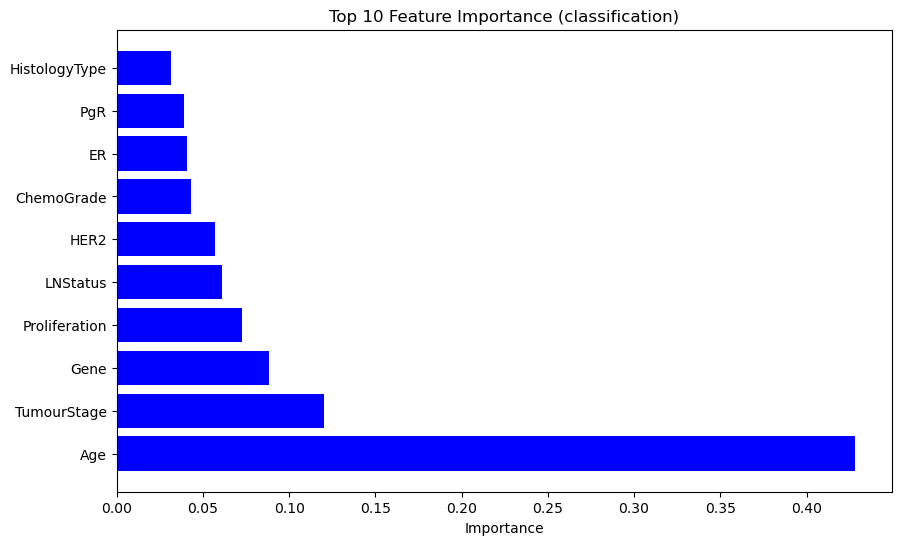

Selected Features: ['Age', 'TumourStage']
Model: Logistic Regression
Balanced Accuracy Score: 0.5000
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        63
         1.0       0.00      0.00      0.00        17

    accuracy                           0.79        80
   macro avg       0.39      0.50      0.44        80
weighted avg       0.62      0.79      0.69        80

Model: Random Forest
Balanced Accuracy Score: 0.4739
              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83        63
         1.0       0.12      0.06      0.08        17

    accuracy                           0.71        80
   macro avg       0.45      0.47      0.45        80
weighted avg       0.64      0.71      0.67        80



D:\Anaconda\envs\MLE\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
D:\Anaconda\envs\MLE\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\MLE\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\MLE\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

In [17]:
# Extract features and targets
X = data.loc[:, 'Age':'Gene']  #  Age to Gene
y_pcr = data['pCR (outcome)']  # classification target

# Handle missing values
X.fillna(X.median(), inplace=True)
y_pcr.fillna(y_pcr.mode()[0], inplace=True)

# Feature Selection
X_selected, selected_features = feature_selection_tree_model(X, y_pcr, task="classification")



# Divide the training set and validation set hierarchically
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)

# Model training and evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Model: {name}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))


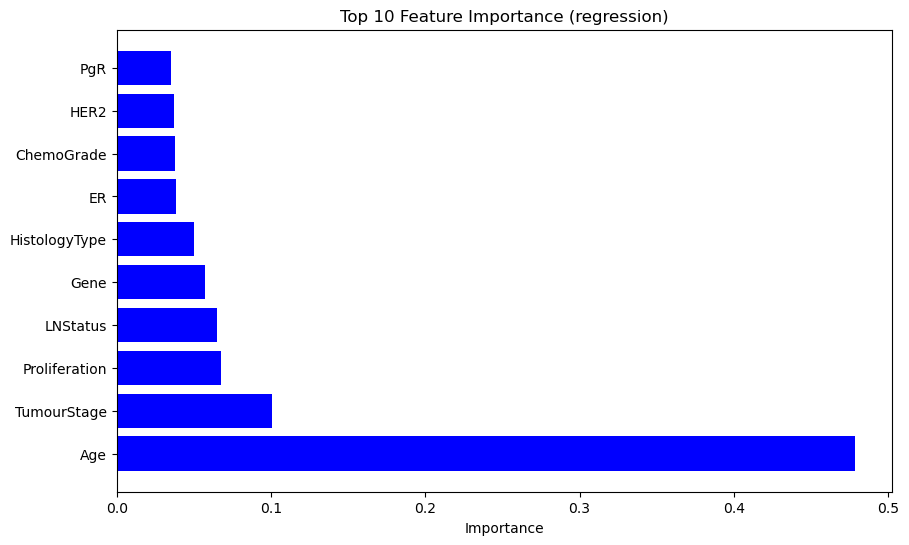

Selected Features: ['Age', 'TumourStage']
Model: Linear Regression
Mean Absolute Error (MAE): 22.0012
Model: Random Forest Regressor
Mean Absolute Error (MAE): 22.5545


D:\Anaconda\envs\MLE\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [15]:
# Extract features and targets
X = data.loc[:, 'Age':'Gene']  # 从 AGE 到 GENE
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归目标

# Handle missing values
X.fillna(X.median(), inplace=True)
y_rfs.fillna(y_rfs.median(), inplace=True)

# Feature Selection
X_selected, selected_features = feature_selection_tree_model(X, y_rfs, task="regression")

# Divide the training set and the validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_rfs, test_size=0.2, random_state=42
)


# Model training and evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42,max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Model: {name}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.4f}")


In [16]:
# Make sure that the classification task targets discrete categories
print(y_train.head())  # Check the value of the target variable
print("Target dtype:", y_train.dtype)  # Check the data type of the target variable

# If the target is a continuous value but should actually be a discrete class, make the conversion
if y_train.dtype in ['float64', 'int64'] and not np.array_equal(y_train, y_train.astype(int)):
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)


3      12.0
18     10.0
202    16.0
250    45.0
274    40.0
Name: RelapseFreeSurvival (outcome), dtype: float64
Target dtype: float64


In [17]:
# Random forest classifier hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_pcr = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

# Run a hyperparameter search
grid_search_pcr.fit(X_train, y_train)
print("Best parameters found:", grid_search_pcr.best_params_)
print("Best balanced accuracy score:", grid_search_pcr.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


D:\Anaconda\envs\MLE\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best balanced accuracy score: 0.013914095583787053


In [18]:
# Random forest regressor hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rfs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,  # 5-Fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Run a hyperparameter search
grid_search_rfs.fit(X_train, y_train)
print("Best parameters found:", grid_search_rfs.best_params_)
print("Best mean absolute error:", -grid_search_rfs.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best mean absolute error: 22.30089142913061


In [18]:
# 提取特征和目标
X = data.loc[:, 'Age':'Gene']  # 从 AGE 到 GENE
y_pcr = data['pCR (outcome)']  # 分类目标

# 处理缺失值
X.fillna(X.median(), inplace=True)
y_pcr.fillna(y_pcr.mode()[0], inplace=True)

# 调用 PCA 进行降维
X_pca, pca_model = feature_selection_pca(X, n_components=10)

# 分层划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)

# 模型训练
model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
model.fit(X_train, y_train)

# 模型评估
y_pred = model.predict(X_val)
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Explained Variance Ratio: [0.34654754 0.15046305 0.11695541 0.10794889 0.08795947 0.06379717
 0.04382868 0.04094723 0.01819804 0.01597381]
Balanced Accuracy Score: 0.5994397759103641
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86        63
         1.0       0.45      0.29      0.36        17

    accuracy                           0.78        80
   macro avg       0.64      0.60      0.61        80
weighted avg       0.75      0.78      0.76        80



In [17]:
# 提取特征和目标
X = data.loc[:, 'Age':'Gene']  # 从 AGE 到 GENE
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归目标

# 处理缺失值
X.fillna(X.median(), inplace=True)
y_rfs.fillna(y_rfs.median(), inplace=True)

# 调用 PCA 进行降维
X_pca, pca_model = feature_selection_pca(X, n_components=10)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y_rfs, test_size=0.2, random_state=42
)

# 模型训练
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 模型评估
y_pred = model.predict(X_val)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_val, y_pred))


Explained Variance Ratio: [0.34654754 0.15046305 0.11695541 0.10794889 0.08795947 0.06379717
 0.04382868 0.04094723 0.01819804 0.01597381]
Mean Absolute Error (MAE): 22.64161458333333
